## 🎁 모듈 로드

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

## 👏 데이터 시각화 세팅

In [2]:
%matplotlib inline
sns.set_style(style="white")
sns.set()

# (Windows OS) 한글 출력을 위한 글꼴 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  
# (MAC OS)
# plt.rcParams['font.family'] = 'AppleGothic'  
# 문자 - (마이너스) 정상 출력을 위한 코드
plt.rcParams['axes.unicode_minus'] = False
# 경고 제거
plt.rcParams.update({'figure.max_open_warning': 0})

# 😒원티드 DB 국민연금 사업장 데이터 분석
---
## 데이터 정보
* 회사 수 : 약 5,000여개
- 월별데이터 : 직원 수, 국민연금 보험료(인원 수에 대한 상한선_최대고지금액이 존재함)
- 년단위 데이터 : 매출액(천원단위)

- [참고](https://github.com/chsop/team4_wanted_onboarding/blob/main/week1/%EB%B0%95%EC%B0%AC%EC%84%9C_onboarding_week1_analysis_v1.1_%ED%81%B4%EB%9F%AC%EC%8A%A4%ED%84%B0%EB%A7%81.ipynb)
---

### 데이터 Read

In [3]:
df = pd.read_csv('company_nps_data.csv',encoding='euc-kr')

In [4]:
# 데이터 형태 확인
df.head(2)

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수
0,233757,41688077,2018,7,8912380,36
1,123464,1760695,2018,3,942380,5


In [5]:
df.describe()

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수
count,9.980100e+04,9.980100e+04,99801.000000,99801.000000,9.980100e+04,99801.000000
mean,2.762982e+05,3.053589e+07,2016.967125,6.714352,9.734079e+06,37.623431
std,1.339032e+05,3.016647e+08,0.976688,3.512966,4.347256e+07,146.947194
min,6.300000e+01,-7.882176e+06,2015.000000,1.000000,0.000000e+00,0.000000
25%,1.655300e+05,1.409760e+06,2016.000000,4.000000,1.181160e+06,6.000000
50%,2.591490e+05,3.573585e+06,2017.000000,7.000000,2.332760e+06,11.000000
75%,3.826560e+05,9.582321e+06,2018.000000,10.000000,5.591860e+06,24.000000
max,5.159723e+06,1.132878e+10,2019.000000,12.000000,9.780673e+08,3133.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99801 entries, 0 to 99800
Data columns (total 6 columns):
회사ID        99801 non-null int64
연매출액        99801 non-null int64
년도          99801 non-null int64
월           99801 non-null int64
월별_연금보험료    99801 non-null int64
월별_직원수      99801 non-null int64
dtypes: int64(6)
memory usage: 4.6 MB


In [7]:
len(set(df['회사ID']))

5000

---
### 데이터 전처리

- 데이터 추가
 * '년도'와 '월' 데이터를 활용하여 시계열데이터(datetime) 추가
- 이상치 제거
 * 연매출액이 0보다 낮은 경우
 * 월별직원수가 0명인 경우

In [8]:
# 데이터 추가(datetime)
df["년월"] = pd.to_datetime(df['년도'].astype(str) + df["월"].astype(str), format='%Y%m')
df = df.sort_values(by=["회사ID", "년월"])

In [9]:
# 이상치 제거
# 이상치 제거를 통해 2개 기업에 대한 데이터 삭제
df = df.drop(index=df.query('연매출액 < 0').index)
df = df.drop(index=df.query('월별_직원수 == 0').index)

In [10]:
# 고유 회사 ID 갯수 확인
len(set(df['회사ID']))
# df.drop_duplicates('회사ID')

4998

In [11]:
# 고유 회사ID 확인
unique = df["회사ID"].unique()
unique

array([     63,      95,     102, ..., 2693684, 3312354, 5159723],
      dtype=int64)

In [12]:
# 비어있는 신규 데이터 프레임 생성
column_names = ["회사ID",	"연매출액", "년도", "월", "월별_연금보험료", "월별_직원수", "년월", "월별_직원수_변동률"]
new_df = pd.DataFrame()
new_df = new_df.reindex(columns=column_names)

In [13]:
# 월별 직원수 변동률 column 추가
for i in unique:
    company = df[df["회사ID"] == i]
    roc = company["월별_직원수"].pct_change().round(2)
    company.insert(len(company.columns), "월별_직원수_변동률", roc)
    new_df = new_df.append(company, sort=False)

In [14]:
# 결측치 처리 : NaN to 0
new_df = new_df.fillna(0)

In [15]:
new_df.head()

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수,년월,월별_직원수_변동률
33039,63.0,1.132878e+10,2018.0,1.0,403119840.0,1006.0,2018-01-01,0.00
74251,63.0,1.132878e+10,2018.0,2.0,406770960.0,1018.0,2018-02-01,0.01
80947,63.0,1.132878e+10,2018.0,3.0,404826240.0,1013.0,2018-03-01,-0.00
80770,63.0,1.132878e+10,2018.0,4.0,404211800.0,1012.0,2018-04-01,-0.00
28110,63.0,1.132878e+10,2018.0,5.0,400339640.0,1002.0,2018-05-01,-0.01


In [16]:
# 데이터 형변환 float64 > int64
columns = ['회사ID', '연매출액', '년도', '월', '월별_연금보험료', '월별_직원수']
for i in columns:
    new_df[i] = new_df[i].astype('int64')

In [17]:
# 급여관련 데이터 추가
# 대한민국 연금보험 비율은 9%로 0.09
new_df['월별_월급총합'] = (new_df['월별_연금보험료'] / 0.09).round(2)
new_df['월별_월급평균'] = (new_df['월별_월급총합'] / df['월별_직원수']).round(2)
new_df["평균_연봉"] = (new_df["월별_월급평균"] * 12)

## ✔데이터 통계
- 4998개 기업의 2015년~2019년까지의 데이터(사업시작 기간은 기업별로 상이)
 * 최초 5000개 기업이었으나, 전처리 과정 중 이상치 제거를 진행함
---

- 최대 연매출액 :  금11,328,779,396,000원(금일십일조삼천이백팔십칠억칠천구백삼십구만육천원)
- 최대 월별 연금보험료 :  금978,067,260원(금구억칠천팔백육만칠천이백육십원)
- 최대 월별 직원수 :  3,133명


- 평균 연매출액 :  금30,544,049,000원(금삼백오억사천사백사만구천원)
- 평균 월별 연금보험료 :  금9,736,289원(금구백칠십삼만육천이백팔십구원)
- 평균 월별 직원수 : 약 38명


- 최소 연매출액 :  금300,000원(금삼십만원)
- 최소 월별 연금보험료 :  금90,000원(금구만원)
- 최소 월별 직원수 :  3명


In [18]:
new_df.head()

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수,년월,월별_직원수_변동률,월별_월급총합,월별_월급평균,평균_연봉
33039,63,11328779396,2018,1,403119840,1006,2018-01-01,0.00,4.479109e+09,4452394.96,53428739.52
74251,63,11328779396,2018,2,406770960,1018,2018-02-01,0.01,4.519677e+09,4439761.62,53277139.44
80947,63,11328779396,2018,3,404826240,1013,2018-03-01,-0.00,4.498069e+09,4440344.85,53284138.20
80770,63,11328779396,2018,4,404211800,1012,2018-04-01,-0.00,4.491242e+09,4437986.39,53255836.68
28110,63,11328779396,2018,5,400339640,1002,2018-05-01,-0.01,4.448218e+09,4439339.54,53272074.48


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000247BE498B00>]],
      dtype=object)

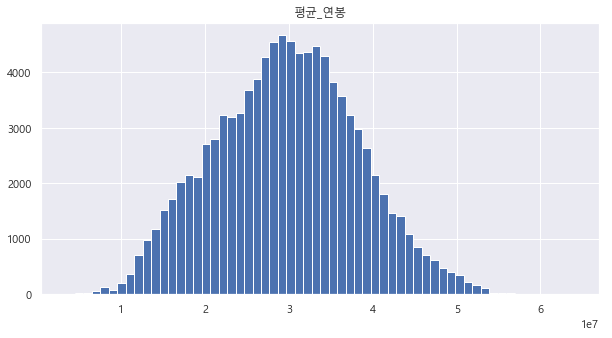

In [19]:
# 데이터 분포 시각화
# 현재의 데이터로 분포를 시각화하게 되면 기업별 분포를 확인 할 수 없음
new_df.hist(bins=60, column=['평균_연봉'],figsize=(10,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000247BD5F67F0>,
      dtype=object)

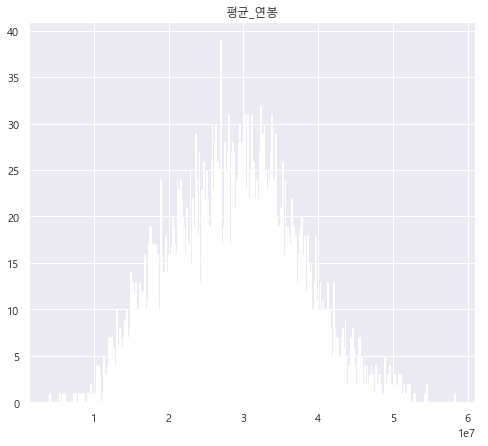

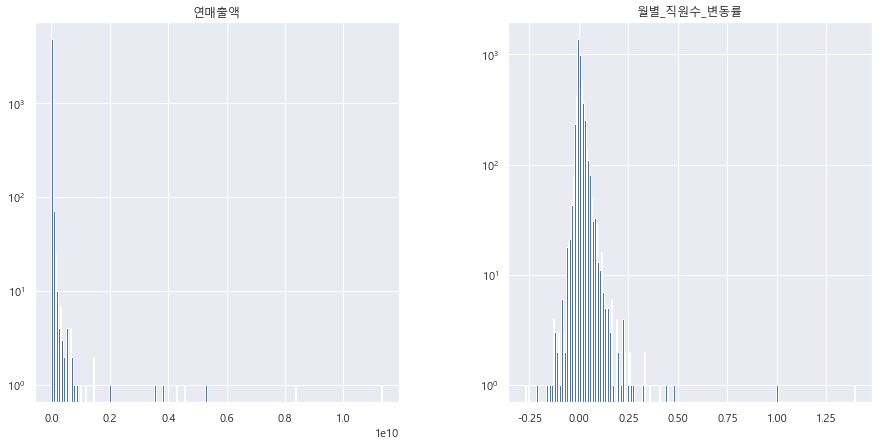

In [20]:
# 회사ID를 기준으로 groupby하여 기업별 평균 데이터 분포 시각화
# 값이 작은 회사가 많아 전체적인 분포확인을 위해 값에 log를 적용
a = new_df.groupby('회사ID').mean()
a.hist(bins=500, column=['평균_연봉'], figsize=(8,7))
a.hist(bins=200, column=['연매출액', '월별_직원수_변동률'],figsize=(15,7), log=True)


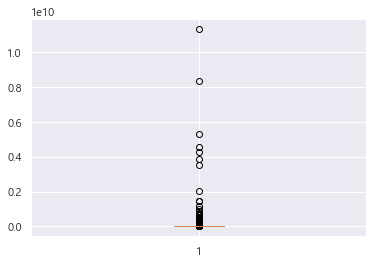

In [21]:
# boxplot을 활용한 이상치 확인
plt.boxplot(a['평균_연봉'])
plt.boxplot(a['연매출액'])
plt.boxplot(a['평균_연봉'])
plt.boxplot(a['평균_연봉'])
plt.show()

In [22]:
# 데이터 이산화
n_bins = 5
bin_labels = list(range(1, n_bins+1))

for i in ['연매출액', '평균_연봉' ,'월별_직원수_변동률']:
    new_column = i+"bin"
    new_df.loc[:,new_column] = pd.cut(new_df[i], n_bins, labels=bin_labels)

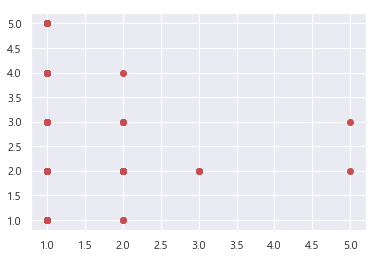

In [23]:
plt.scatter(new_df['월별_직원수_변동률bin'], new_df['평균_연봉bin'], c='r')
plt.show()

In [24]:
bin5 = new_df[new_df['월별_직원수_변동률bin'] >= 2]

In [25]:
bin5.describe()

,회사ID,연매출액,년도,월,월별_연금보험료,월별_직원수,월별_직원수_변동률,월별_월급총합,월별_월급평균,평균_연봉
count,18.000000,1.800000e+01,18.000000,18.000000,1.800000e+01,18.000000,18.000000,1.800000e+01,1.800000e+01,1.800000e+01
mean,316191.055556,7.969711e+06,2017.166667,4.888889,1.091540e+07,66.944444,5.227778,1.212823e+08,1.965868e+06,2.359042e+07
std,169324.183576,1.069080e+07,0.923548,4.171174,2.630163e+07,164.482959,4.324704,2.922403e+08,6.075275e+05,7.290330e+06
min,3611.000000,4.603310e+05,2016.000000,1.000000,1.177460e+06,11.000000,2.670000,1.308289e+07,8.721926e+05,1.046631e+07
25%,233827.000000,1.189206e+06,2016.000000,2.000000,2.515585e+06,15.000000,2.750000,2.795094e+07,1.584709e+06,1.901651e+07
50%,383052.000000,2.962794e+06,2017.500000,2.500000,3.714340e+06,21.500000,3.265000,4.127044e+07,1.894040e+06,2.272848e+07
75%,454938.750000,1.111653e+07,2018.000000,8.250000,6.143000e+06,29.500000,5.997500,6.825556e+07,2.314499e+06,2.777398e+07
max,560267.000000,4.028536e+07,2018.000000,12.000000,1.151580e+08,719.000000,17.000000,1.279533e+09,3.446081e+06,4.135297e+07


In [59]:
# 참고링크 : https://wikidocs.net/83562
# 정규분포를 벗어나는 값 제거
# 사분위수범위(IQR = interquartile Range) 산출
# 1사분위수(25percentile, lower quartile)
quartile_1 = a['평균_연봉'].quantile(0.25)

# 3사분위수(75percentile, upper quartile)
quartile_3 = a['평균_연봉'].quantile(0.75) 
IQR = quartile_3 - quartile_1
search_df = a[(a['평균_연봉'] < (quartile_1 - 1.5 * IQR)) | (a['평균_연봉'] > (quartile_3 + 1.5 * IQR))]

In [27]:
a = a.drop(search_df.index, axis=0)

{'whiskers': [<matplotlib.lines.Line2D at 0x247bf4c1e48>,
 'caps': [<matplotlib.lines.Line2D at 0x247bf4cb588>,
 'boxes': [<matplotlib.lines.Line2D at 0x247bf4c1a20>],
 'medians': [<matplotlib.lines.Line2D at 0x247bf4cbc88>],
 'fliers': [<matplotlib.lines.Line2D at 0x247bf4cbda0>],
 'means': []}

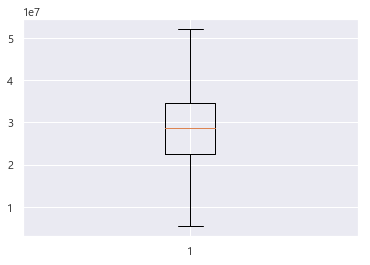

In [28]:
plt.boxplot(a['평균_연봉'])

In [79]:
a

,연매출액,년도,월,월별_연금보험료,월별_직원수,월별_직원수_변동률,월별_월급총합,월별_월급평균,평균_연봉
회사ID,,,,,,,,,
102,7.426589e+08,2018.000000,8.500000,1.737695e+08,752.125000,0.008750,1.930772e+09,2.567909e+06,3.081491e+07
295,8.377670e+07,2018.000000,8.500000,7.731204e+07,259.500000,-0.020000,8.590226e+08,3.312995e+06,3.975594e+07
414,1.973277e+07,2018.000000,6.500000,7.759019e+07,247.583333,-0.000833,8.621133e+08,3.482024e+06,4.178429e+07
597,2.081416e+08,2018.000000,6.500000,5.479775e+07,178.833333,0.006667,6.088639e+08,3.408278e+06,4.089934e+07
786,6.551457e+07,2018.000000,6.500000,4.605384e+07,167.416667,0.015000,5.117094e+08,3.052708e+06,3.663250e+07
917,4.284371e+07,2018.000000,6.500000,4.811188e+07,148.666667,0.007500,5.345764e+08,3.594537e+06,4.313444e+07
1052,1.215784e+06,2018.000000,6.500000,3.025255e+06,18.416667,0.012500,3.361394e+07,1.825129e+06,2.190155e+07
1125,5.371387e+07,2018.000000,6.500000,2.839946e+07,92.833333,0.205833,3.155496e+08,3.272314e+06,3.926777e+07
1715,7.844389e+06,2018.000000,6.500000,9.141352e+06,38.833333,-0.003333,1.015706e+08,2.616399e+06,3.139679e+07


In [133]:
k_unicorn_list = pd.read_csv('k_unicorn_list.csv',encoding='utf-8')
k_unicorn_list['평균월급'] = (k_unicorn_list['평균연봉']/12).round(1)
k_unicorn_list

,기업명,창업연도(년),창업연도(월),등재시점(년),등재시점(월),주요브랜드,업종,직원수,평균연봉,평균월급
0,쿠팡,2010,8,2014,5,쿠팡,온라인 쇼핑,6372,38610000,3217500.0
1,크래프톤,2007,3,2018,8,"테라, 배틀그라운드",온라인 게임,730,56990000,4749166.7
2,비바리퍼블리카,2013,4,2018,12,토스,핀테크,717,52997000,4416416.7
3,위메프,2010,5,2015,9,위메프,온라인 쇼핑,1500,40250000,3354166.7
4,무신사,2012,6,2019,11,무신사,패션커머스,510,32700000,2725000.0
5,지피클럽,2003,9,2018,10,JM솔루션 강블리라이프,화장품,170,33370000,2780833.3
6,엘앤피코스메틱,2009,4,2016,1,메디힐,화장품,177,44000000,3666666.7
7,에이프로젠,2000,4,2019,5,GS071,바이오,115,42090000,3507500.0
8,야놀자,2007,2,2019,6,야놀자,여가 플랫폼,1000,47860000,3988333.3
9,쏘카,2011,10,2020,10,쏘카,차량공유,335,43270000,3605833.3


In [134]:
k_unicorn_pay_mean = k_unicorn_list['평균월급'].mean()
k_unicorn_list[(k_unicorn_list['등재시점(년)'] > 2015) & (k_unicorn_list['등재시점(년)'] < 2019)]

# k_unicorn_pay_mean

,기업명,창업연도(년),창업연도(월),등재시점(년),등재시점(월),주요브랜드,업종,직원수,평균연봉,평균월급
1,크래프톤,2007,3,2018,8,"테라, 배틀그라운드",온라인 게임,730,56990000,4749166.7
2,비바리퍼블리카,2013,4,2018,12,토스,핀테크,717,52997000,4416416.7
5,지피클럽,2003,9,2018,10,JM솔루션 강블리라이프,화장품,170,33370000,2780833.3
6,엘앤피코스메틱,2009,4,2016,1,메디힐,화장품,177,44000000,3666666.7


In [135]:
c = a[a['월별_월급평균'] > k_unicorn_pay_mean]

In [136]:
c

,연매출액,년도,월,월별_연금보험료,월별_직원수,월별_직원수_변동률,월별_월급총합,월별_월급평균,평균_연봉
회사ID,,,,,,,,,
2745,7.145408e+06,2018.000000,6.500000,2.137405e+07,60.583333,0.005000,2.374894e+08,3.921301e+06,4.705562e+07
2807,2.546090e+07,2018.000000,6.500000,2.050861e+07,54.166667,-0.011667,2.278734e+08,4.210583e+06,5.052700e+07
2842,1.138770e+08,2018.000000,6.500000,2.377390e+07,63.250000,-0.007500,2.641545e+08,4.181486e+06,5.017783e+07
5202,9.002770e+07,2018.000000,6.500000,1.339771e+07,40.666667,0.047500,1.488635e+08,3.652949e+06,4.383539e+07
5452,2.523765e+08,2018.000000,7.500000,1.534591e+07,39.700000,-0.003000,1.705102e+08,4.294955e+06,5.153946e+07
8208,4.151961e+06,2019.000000,6.500000,1.687663e+07,46.250000,0.031667,1.875181e+08,4.052763e+06,4.863315e+07
8268,5.285115e+06,2018.000000,6.500000,1.023517e+07,29.000000,-0.005000,1.137241e+08,3.927257e+06,4.712709e+07
13948,2.542179e+07,2018.000000,6.500000,4.866008e+06,12.833333,-0.024167,5.406676e+07,4.224268e+06,5.069122e+07
23435,3.344878e+06,2018.000000,6.500000,4.174870e+06,12.083333,0.008333,4.638744e+07,3.841561e+06,4.609873e+07


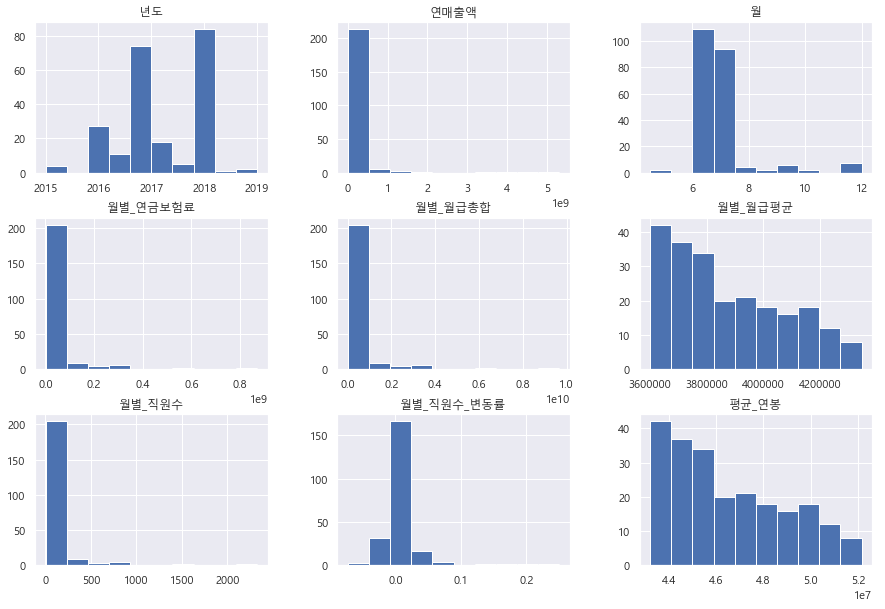

In [115]:
c.hist(figsize=(15,10))
plt.show()

In [146]:
bbbb =new_df.groupby(['회사ID', '년도'])['월별_월급평균'].mean().unstack()

In [181]:
bbbb.loc[:,2016:2018].dropna()

년도,2016,2017,2018
회사ID,,,
14271,2.736252e+06,2.425698e+06,2.335655e+06
59533,1.015467e+06,1.011606e+06,1.007838e+06
122968,2.396381e+06,2.474782e+06,2.361226e+06
123082,1.652752e+06,1.738289e+06,1.905497e+06
123219,1.921336e+06,1.955926e+06,2.328344e+06
123235,2.976367e+06,3.105094e+06,3.154270e+06
123464,1.934426e+06,2.215174e+06,1.995413e+06
123649,1.771648e+06,1.881573e+06,2.023573e+06
123882,2.000551e+06,2.028544e+06,2.435621e+06


In [183]:
bbbb_2016_2018 = bbbb.loc[:,2016:2018].dropna().index
bbbb_2016_2018

Int64Index([ 14271,  59533, 122968, 123082, 123219, 123235, 123464, 123649,
            123882, 124181,
            ...
            509060, 510329, 511468, 512107, 512308, 513218, 514152, 514934,
            515264, 516653],
           dtype='int64', name='회사ID', length=1156)

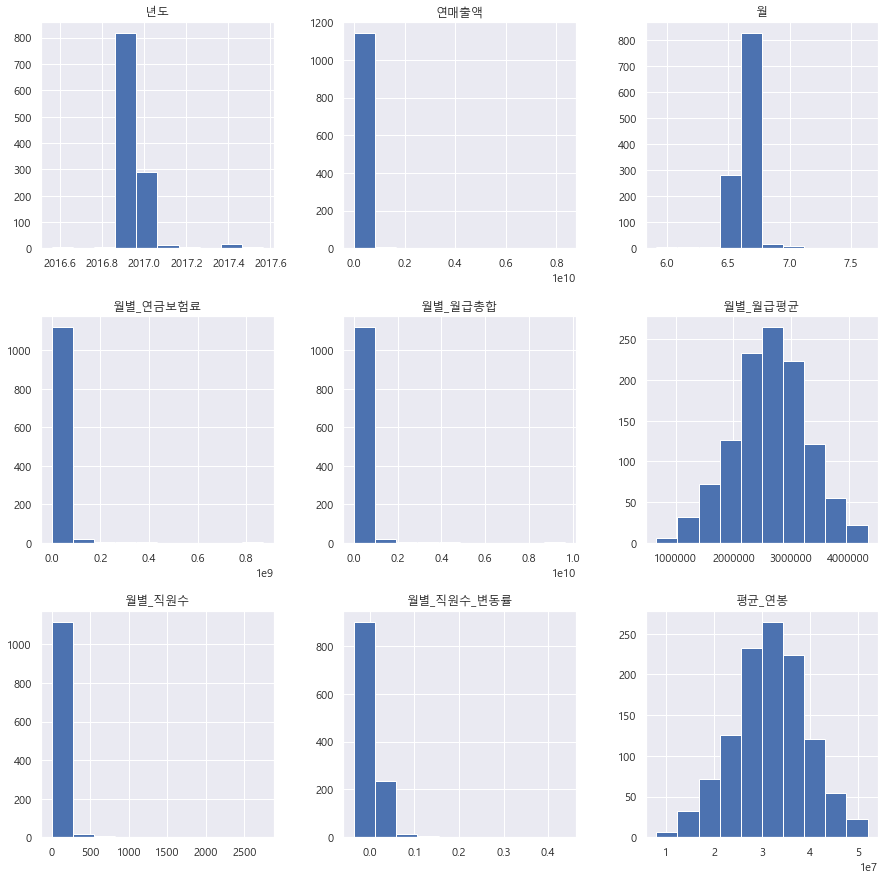

In [200]:
cccc =a.loc[bbbb_2016_2018]
cccc.hist(bins=10, figsize=(15,15))
plt.show()